<a href="https://colab.research.google.com/github/cozzin/Practical-Deep-Learning-for-Coders/blob/main/04_mnist_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.1 MB/s 
     |████████████████████████████████| 189 kB 49.5 MB/s 
     |████████████████████████████████| 1.2 MB 24.3 MB/s 
     |████████████████████████████████| 46 kB 3.7 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 
     |████████████████████████████████| 51 kB 277 kB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

이번챕터 배울 배용

- 학습이 처리되는 내부 살펴봄
- 딥러닝 개념
- 딥러닝 기초 도구
- 배열과 텐서의 역할
- 브로드캐스팅
    
    배열과 텐서를 효과적으로 사용하는 기법
    
- 확률적 경사 하강법
    
    Stochastic Gradient Descent
    
    파라미터의 가중치를 자동으로 갱신
    
- 손실 함수의 종류
    
    기본적인 분류작업에서 선택 가능
    
- 미니배치의 역할
- 신경망의 기본 작동
- 배운 내용 종합

## Pixels: The Foundations of Computer Vision

* 컴퓨터가 이미지를 다루는 방식 이해하기
* MINST: 손글씨 데이터셋

In order to understand what happens in a computer vision model, we first have to understand how computers handle images. We'll use one of the most famous datasets in computer vision, [MNIST](https://en.wikipedia.org/wiki/MNIST_database), for our experiments. MNIST contains images of handwritten digits, collected by the National Institute of Standards and Technology and collated into a machine learning dataset by Yann Lecun and his colleagues. Lecun used MNIST in 1998 in [Lenet-5](http://yann.lecun.com/exdb/lenet/), the first computer system to demonstrate practically useful recognition of handwritten digit sequences. This was one of the most important breakthroughs in the history of AI.

## Sidebar: Tenacity and Deep Learning

(좋은 내용인데 핵심은 아님)

The story of deep learning is one of tenacity and grit by a handful of dedicated researchers. After early hopes (and hype!) neural networks went out of favor in the 1990's and 2000's, and just a handful of researchers kept trying to make them work well. Three of them, Yann Lecun, Yoshua Bengio, and Geoffrey Hinton, were awarded the highest honor in computer science, the Turing Award (generally considered the "Nobel Prize of computer science"), in 2018 after triumphing despite the deep skepticism and disinterest of the wider machine learning and statistics community.

Geoff Hinton has told of how even academic papers showing dramatically better results than anything previously published would be rejected by top journals and conferences, just because they used a neural network. Yann Lecun's work on convolutional neural networks, which we will study in the next section, showed that these models could read handwritten text—something that had never been achieved before. However, his breakthrough was ignored by most researchers, even as it was used commercially to read 10% of the checks in the US!

In addition to these three Turing Award winners, there are many other researchers who have battled to get us to where we are today. For instance, Jurgen Schmidhuber (who many believe should have shared in the Turing Award) pioneered many important ideas, including working with his student Sepp Hochreiter on the long short-term memory (LSTM) architecture (widely used for speech recognition and other text modeling tasks, and used in the IMDb example in <<chapter_intro>>). Perhaps most important of all, Paul Werbos in 1974 invented back-propagation for neural networks, the technique shown in this chapter and used universally for training neural networks ([Werbos 1994](https://books.google.com/books/about/The_Roots_of_Backpropagation.html?id=WdR3OOM2gBwC)). His development was almost entirely ignored for decades, but today it is considered the most important foundation of modern AI.

There is a lesson here for all of us! On your deep learning journey you will face many obstacles, both technical, and (even more difficult) posed by people around you who don't believe you'll be successful. There's one *guaranteed* way to fail, and that's to stop trying. We've seen that the only consistent trait amongst every fast.ai student that's gone on to be a world-class practitioner is that they are all very tenacious.

## End sidebar

## 3, 7 이미지 분류 모델 만들기

For this initial tutorial we are just going to try to create a model that can classify any image as a 3 or a 7. So let's download a sample of MNIST that contains images of just these digits:

In [ ]:
# MINST 샘플 데이터셋 다운로드
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
#hide
Path.BASE_PATH = path

We can see what's in this directory by using `ls`, a method added by fastai. This method returns an object of a special fastai class called `L`, which has all the same functionality of Python's built-in `list`, plus a lot more. One of its handy features is that, when printed, it displays the count of items, before listing the items themselves (if there are more than 10 items, it just shows the first few):

In [ ]:
# 디렉토리 내용 확인
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Let's see what's inside the training set:

In [ ]:
# 학습, 검증 데이터셋 별도 폴더에 있음
(path/'train').ls() # 학습 데이터 폴더 확인

(#2) [Path('train/7'),Path('train/3')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the *labels* (or targets) in this dataset. Let's take a look in one of these folders (using `sorted` to ensure we all get the same order of files):

In [ ]:
# '3', '7'을 레이블 or 타겟 이라고 부름
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

As we might expect, it's full of image files. Let’s take a look at one now. Here’s an image of a handwritten number 3, taken from the famous MNIST dataset of handwritten numbers:

In [ ]:
# 어떤 이미지 파일이 있나 살펴보기
im3_path = threes[1]
im3 = Image.open(im3_path) # 파이썬 영상 처리 라이브러리 `PIL`에 있는 `Image` 클래스 사용
im3

Here we are using the `Image` class from the *Python Imaging Library* (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.

In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a *NumPy array* or a *PyTorch tensor*. For instance, here's what a section of the image looks like, converted to a NumPy array:

In [ ]:
# NumPy.array 사용해서 
# 이미지를 구성하는 숫자 확인
array(im3)[4:10,4:10] # 4~9 범위의 데이터 표현

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

The `4:10` indicates we requested the rows from index 4 (included) to 10 (not included) and the same for the columns. NumPy indexes from top to bottom and left to right, so this section is located in the top-left corner of the image. Here's the same thing as a PyTorch tensor:

In [ ]:
# PyTorch.tensor 사용해서
# 이미지를 구성하는 숫자 확인
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

In [ ]:
#Pandas.DataFrame으로 표현
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


<img width="453" id="output_pd_pixels" src="https://github.com/fastai/fastbook/blob/master/images/att_00058.png?raw=1">

You can see that the background white pixels are stored as the number 0, black is the number 255, and shades of gray are between the two. The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels. (This is much smaller than an image that you would get from a phone camera, which has millions of pixels, but is a convenient size for our initial learning and experiments. We will build up to bigger, full-color images soon.)

So, now you've seen what an image looks like to a computer, let's recall our goal: create a model that can recognize 3s and 7s. How might you go about getting a computer to do that?

> Warning: Stop and Think!: Before you read on, take a moment to think about how a computer might be able to recognize these two different digits. What kinds of features might it be able to look at? How might it be able to identify these features? How could it combine them together? Learning works best when you try to solve problems yourself, rather than just reading somebody else's answers; so step away from this book for a few minutes, grab a piece of paper and pen, and jot some ideas down…

컴퓨터가 3, 7 을 어떻게 분류할지 상상해보기...
음... 세로 방향 중간 지점부터 직선으로 된 형태가 나오면 7일 가능성이 높을 것 같음

## First Try: Pixel Similarity
## 첫 번째 시도: 픽셀 유사성

So, here is a first idea: how about we find the average pixel value for every pixel of the 3s, then do the same for the 7s. This will give us two group averages, defining what we might call the "ideal" 3 and 7. Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. This certainly seems like it should be better than nothing, so it will make a good baseline.

* 숫자 3과 7에 대한 평균 픽셀값 추출
* 입력된 이미지가 어느쪽에 가까운지 계산
* 이걸 baseline으로 삼을 수 있음

> jargon: Baseline: A simple model which you are confident should perform reasonably well. It should be very simple to implement, and very easy to test, so that you can then test each of your improved ideas, and make sure they are always better than your baseline. Without starting with a sensible baseline, it is very difficult to know whether your super-fancy models are actually any good. One good approach to creating a baseline is doing what we have done here: think of a simple, easy-to-implement model. Another good approach is to search around to find other people that have solved similar problems to yours, and download and run their code on your dataset. Ideally, try both of these!

Step one for our simple model is to get the average of pixel values for each of our two groups. In the process of doing this, we will learn a lot of neat Python numeric programming tricks!

Let's create a tensor containing all of our 3s stacked together. We already know how to create a tensor containing a single image. To create a tensor containing all the images in a directory, we will first use a Python list comprehension to create a plain list of the single image tensors.

We will use Jupyter to do some little checks of our work along the way—in this case, making sure that the number of returned items seems reasonable:

In [ ]:
# 3, 7 디렉토리 모든 이미지를 텐서로 만들기
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

### 추가설명: 파이썬 리스트 컴프리헨션 (list comprehension)
반복문을 별도로 쓰지 않고 리스트를 간편하게 만들 수 있음
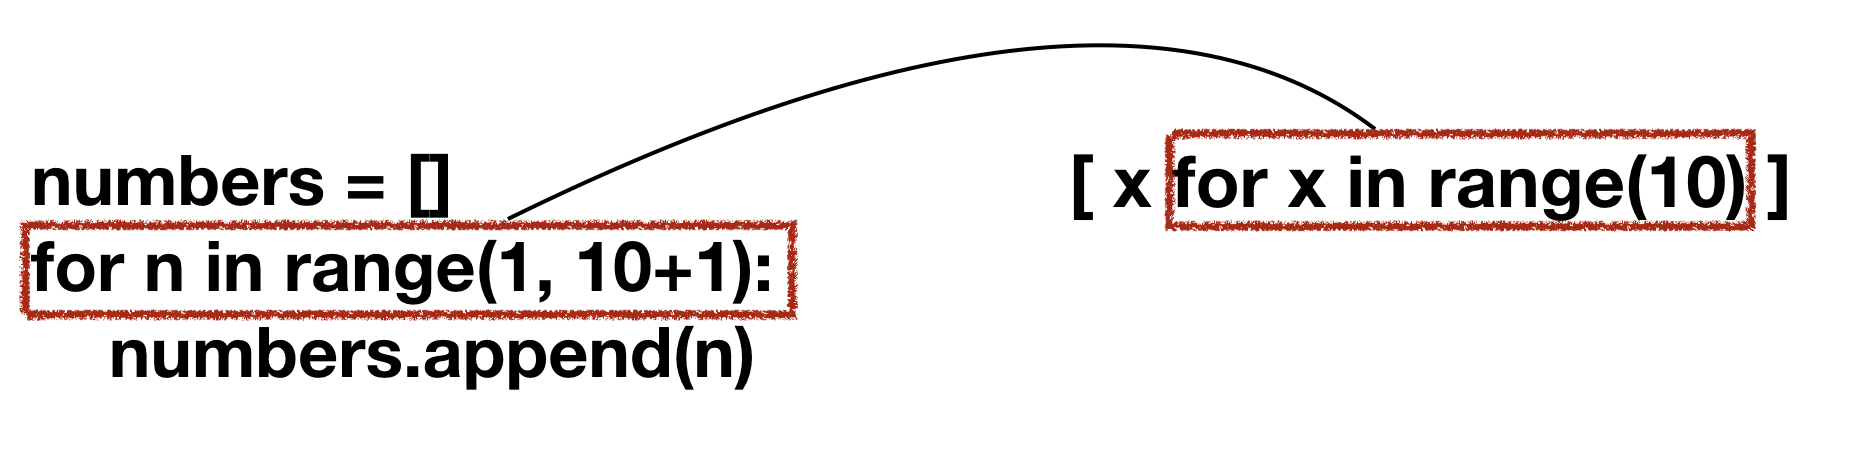

> note: List Comprehensions: List and dictionary comprehensions are a wonderful feature of Python. Many Python programmers use them every day, including the authors of this book—they are part of "idiomatic Python." But programmers coming from other languages may have never seen them before. There are a lot of great tutorials just a web search away, so we won't spend a long time discussing them now. Here is a quick explanation and example to get you started. A list comprehension looks like this: `new_list = [f(o) for o in a_list if o>0]`. This will return every element of `a_list` that is greater than 0, after passing it to the function `f`. There are three parts here: the collection you are iterating over (`a_list`), an optional filter (`if o>0`), and something to do to each element (`f(o)`). It's not only shorter to write but way faster than the alternative ways of creating the same list with a loop.

We'll also check that one of the images looks okay. Since we now have tensors (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's `show_image` function to display it:

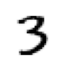

In [ ]:
# 텐서를 이미지로 보여줌
# show_image 함수는 fastai에 있음
show_image(three_tensors[1]);

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a *rank-3 tensor*. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called `stack` that we can use for this purpose.

Some operations in PyTorch, such as taking a mean, require us to *cast* our integer types to float types. Since we'll be needing this later, we'll also cast our stacked tensor to `float` now. Casting in PyTorch is as simple as typing the name of the type you wish to cast to, and treating it as a method.

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:

In [ ]:
# 3차원 텐서로 쌓아올림
# rank-3 텐서라고 부름
# torch.stack()에서 그 작업을 해줌
stacked_sevens = torch.stack(seven_tensors).float()/255 # 텐서 내용물을 float 형변환 후에 /255 해줌
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape # 각 축의 길이를 표현. 이미지 6131장, 28x28 픽셀로 구성

torch.Size([6131, 28, 28])

Perhaps the most important attribute of a tensor is its *shape*. This tells you the length of each axis. In this case, we can see that we have 6,131 images, each of size 28×28 pixels. There is nothing specifically about this tensor that says that the first axis is the number of images, the second is the height, and the third is the width—the semantics of a tensor are entirely up to us, and how we construct it. As far as PyTorch is concerned, it is just a bunch of numbers in memory.

The *length* of a tensor's shape is its rank:

In [ ]:
len(stacked_threes.shape) # 3축, 3차원

3

It is really important for you to commit to memory and practice these bits of tensor jargon: _rank_ is the number of axes or dimensions in a tensor; _shape_ is the size of each axis of a tensor.

> A: Watch out because the term "dimension" is sometimes used in two ways. Consider that we live in "three-dimensonal space" where a physical position can be described by a 3-vector `v`. But according to PyTorch, the attribute `v.ndim` (which sure looks like the "number of dimensions" of `v`) equals one, not three! Why? Because `v` is a vector, which is a tensor of rank one, meaning that it has only one _axis_ (even if that axis has a length of three). In other words, sometimes dimension is used for the size of an axis ("space is three-dimensional"); other times, it is used for the rank, or the number of axes ("a matrix has two dimensions"). When confused, I find it helpful to translate all statements into terms of rank, axis, and length, which are unambiguous terms.

We can also get a tensor's rank directly with `ndim`:

In [ ]:
stacked_threes.ndim # nidm 으로 랭크 확인. 위의 코드랑 똑같음

3

Finally, we can compute what the ideal 3 looks like. We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.

In other words, for every pixel position, this will compute the average of that pixel over all images. The result will be one value for every pixel position, or a single image. Here it is:

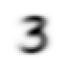

In [ ]:
# 평균 이미지
# 0을 넣으면서, 0번째 차원 = 색인 이라고 하는데 무슨 말인지 잘 모르겠음. 0을 넣어야 제대로된 이미지 구할 수 있음
mean3 = stacked_threes.mean(0)
show_image(mean3);

According to this dataset, this is the ideal number 3! (You may not like it, but this is what peak number 3 performance looks like.) You can see how it's very dark where all the images agree it should be dark, but it becomes wispy and blurry where the images disagree. 

Let's do the same thing for the 7s, but put all the steps together at once to save some time:

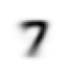

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Let's now pick an arbitrary 3 and measure its *distance* from our "ideal digits."

> stop: Stop and Think!: How would you calculate how similar a particular image is to each of our ideal digits? Remember to step away from this book and jot down some ideas before you move on! Research shows that recall and understanding improves dramatically when you are engaged with the learning process by solving problems, experimenting, and trying new ideas yourself

Here's a sample 3:

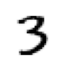

In [ ]:
# 임의로 숫자 선택
a_3 = stacked_threes[1]
show_image(a_3);

How can we determine its distance from our ideal 3? We can't just add up the differences between the pixels of this image and the ideal digit. Some differences will be positive while others will be negative, and these differences will cancel out, resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal. That would be misleading!

To avoid this, there are two main ways data scientists measure distance in this context:

- Take the mean of the *absolute value* of differences (absolute value is the function that replaces negative values with positive values). This is called the *mean absolute difference* or *L1 norm* 차이 절대값의 평균. 평균절대차
- Take the mean of the *square* of differences (which makes everything positive) and then take the *square root* (which undoes the squaring). This is called the *root mean squared error* (RMSE) or *L2 norm*. 차이의 제곱에 루트 씌우기. 평균제곱근오차

> important: It's Okay to Have Forgotten Your Math: In this book we generally assume that you have completed high school math, and remember at least some of it... But everybody forgets some things! It all depends on what you happen to have had reason to practice in the meantime. Perhaps you have forgotten what a _square root_ is, or exactly how they work. No problem! Any time you come across a maths concept that is not explained fully in this book, don't just keep moving on; instead, stop and look it up. Make sure you understand the basic idea, how it works, and why we might be using it. One of the best places to refresh your understanding is Khan Academy. For instance, Khan Academy has a great [introduction to square roots](https://www.khanacademy.org/math/algebra/x2f8bb11595b61c86:rational-exponents-radicals/x2f8bb11595b61c86:radicals/v/understanding-square-roots).

Let's try both of these now:

In [ ]:
# a_3는 앞에서 선언한 임의의 이미지

dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [ ]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. So our simple model will give the right prediction in this case.

PyTorch already provides both of these as *loss functions*. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as `F` (and is available by default under that name in fastai):

In [ ]:
# 손실 함수 돌려보기
# 이걸 사용하면 위와 같은 식을 직접 작성하지 않아도 됨

F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

Here `mse` stands for *mean squared error*, and `l1` refers to the standard mathematical jargon for *mean absolute value* (in math it's called the *L1 norm*).

> S: Intuitively, the difference between L1 norm and mean squared error (MSE) is that the latter will penalize bigger mistakes more heavily than the former (and be more lenient with small mistakes).

평균제곱오차는 L1 노름 보다 실수에 더 강한 패널티 줌

> J: When I first came across this "L1" thingie, I looked it up to see what on earth it meant. I found on Google that it is a _vector norm_ using _absolute value_, so looked up _vector norm_ and started reading: _Given a vector space V over a field F of the real or complex numbers, a norm on V is a nonnegative-valued any function p: V → \[0,+∞) with the following properties: For all a ∈ F and all u, v ∈ V, p(u + v) ≤ p(u) + p(v)..._ Then I stopped reading. "Ugh, I'll never understand math!" I thought, for the thousandth time. Since then I've learned that every time these complex mathy bits of jargon come up in practice, it turns out I can replace them with a tiny bit of code! Like, the _L1 loss_ is just equal to `(a-b).abs().mean()`, where `a` and `b` are tensors. I guess mathy folks just think differently than me... I'll make sure in this book that every time some mathy jargon comes up, I'll give you the little bit of code it's equal to as well, and explain in common-sense terms what's going on.

We just completed various mathematical operations on PyTorch tensors. If you've done some numeric programming in NumPy before, you may recognize these as being similar to NumPy arrays. Let's have a look at those two very important data structures.

### NumPy Arrays and PyTorch Tensors

* 책에서는 넘파이 보다 파이토치 텐서를 사용해서 설명함. 파이토치에 딥러닝을 위한 GPU 활용 기능이 더 많음
* 넘파이, 파이토치 써야하는 이유: 빠른 속도
* 넘파이: 다차원 테이블 표현 쉬움
* 파이토치 텐서
  * 넘파이 배열과 거의 같음
  * 하지만 기본적 수치형 데이터만 사용가능
  * 크기가 들쭉날쭉하면 안됨
  * GPU 최적화된 계산


[NumPy](https://numpy.org/) is the most widely used library for scientific and numeric programming in Python. It provides very similar functionality and a very similar API to that provided by PyTorch; however, it does not support using the GPU or calculating gradients, which are both critical for deep learning. Therefore, in this book we will generally use PyTorch tensors instead of NumPy arrays, where possible.

(Note that fastai adds some features to NumPy and PyTorch to make them a bit more similar to each other. If any code in this book doesn't work on your computer, it's possible that you forgot to include a line like this at the start of your notebook: `from fastai.vision.all import *`.)

But what are arrays and tensors, and why should you care?

Python is slow compared to many languages. Anything fast in Python, NumPy, or PyTorch is likely to be a wrapper for a compiled object written (and optimized) in another language—specifically C. In fact, **NumPy arrays and PyTorch tensors can finish computations many thousands of times faster than using pure Python.**

A NumPy array is a multidimensional table of data, with all items of the same type. Since that can be any type at all, they can even be arrays of arrays, with the innermost arrays potentially being different sizes—this is called a "jagged array." By "multidimensional table" we mean, for instance, a list (dimension of one), a table or matrix (dimension of two), a "table of tables" or "cube" (dimension of three), and so forth. If the items are all of some simple type such as integer or float, then NumPy will store them as a compact C data structure in memory. This is where NumPy shines. NumPy has a wide variety of operators and methods that can run computations on these compact structures at the same speed as optimized C, because they are written in optimized C.

A PyTorch tensor is nearly the same thing as a NumPy array, but with an additional restriction that unlocks some additional capabilities. It's the same in that it, too, is a multidimensional table of data, with all items of the same type. However, the restriction is that a tensor cannot use just any old type—it has to use a single basic numeric type for all components. For example, a PyTorch tensor cannot be jagged. It is always a regularly shaped multidimensional rectangular structure.

The vast majority of methods and operators supported by NumPy on these structures are also supported by PyTorch, but PyTorch tensors have additional capabilities. One major capability is that these structures can live on the GPU, in which case their computation will be optimized for the GPU and can run much faster (given lots of values to work on). In addition, PyTorch can automatically calculate derivatives of these operations, including combinations of operations. As you'll see, it would be impossible to do deep learning in practice without this capability.

> S: If you don't know what C is, don't worry as you won't need it at all. In a nutshell, it's a low-level  (low-level means more similar to the language that computers use internally) language that is very fast compared to Python. To take advantage of its speed while programming in Python, try to avoid as much as possible writing loops, and replace them by commands that work directly on arrays or tensors.

Perhaps the most important new coding skill for a Python programmer to learn is how to effectively use the array/tensor APIs. We will be showing lots more tricks later in this book, but here's a summary of the key things you need to know for now.

To create an array or tensor, pass a list (or list of lists, or list of lists of lists, etc.) to `array()` or `tensor()`:

In [ ]:
data = [[1,2,3],[4,5,6]] # 중첩 가능
arr = array (data)
tns = tensor(data)

In [ ]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

All the operations that follow are shown on tensors, but the syntax and results for NumPy arrays is identical.

You can select a row (note that, like lists in Python, tensors are 0-indexed so 1 refers to the second row/column):

In [ ]:
tns[1]

tensor([4, 5, 6])

or a column, by using `:` to indicate *all of the first axis* (we sometimes refer to the dimensions of tensors/arrays as *axes*):

In [ ]:
tns[:,1] # 1번 축

tensor([2, 5])

You can combine these with Python slice syntax (`[start:end]` with `end` being excluded) to select part of a row or column:

In [ ]:
tns[1,1:3] # 1행, 1이상 ~ 3미만

tensor([5, 6])

And you can use the standard operators such as `+`, `-`, `*`, `/`:

In [ ]:
tns+1 # operator 바로 사용하는게 장점으로 보임

tensor([[2, 3, 4],
        [5, 6, 7]])

Tensors have a type:

In [ ]:
tns.type()

'torch.LongTensor'

And will automatically change type as needed, for example from `int` to `float`:

In [ ]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

So, is our baseline model any good? To quantify this, we must define a metric.

## Computing Metrics Using Broadcasting

* **평가지표**: 모델이 얼마나 좋은지 평가
* **정확도**를 평가 지표로 사용
* 평가 지표를 계산하려는 대상: **검증용 데이터셋**

Recall that a metric is a number that is calculated based on the predictions of our model, and the correct labels in our dataset, in order to tell us how good our model is. For instance, we could use either of the functions we saw in the previous section, mean squared error, or mean absolute error, and take the average of them over the whole dataset. However, neither of these are numbers that are very understandable to most people; in practice, we normally use *accuracy* as the metric for classification models.

As we've discussed, we want to calculate our metric over a *validation set*. This is so that we don't inadvertently overfit—that is, train a model to work well only on our training data. This is not really a risk with the pixel similarity model we're using here as a first try, since it has no trained components, but we'll use a validation set anyway to follow normal practices and to be ready for our second try later.

To get a validation set we need to remove some of the data from training entirely, so it is not seen by the model at all. As it turns out, the creators of the MNIST dataset have already done this for us. Do you remember how there was a whole separate directory called *valid*? That's what this directory is for!

So to start with, let's create tensors for our 3s and 7s from that directory. These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image:

In [ ]:
# 검증용 텐서 만들기
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape # shape 점검하는 습관 들이면 좋다고 함

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

It's good to get in the habit of checking shapes as you go. Here we see two tensors, one representing the 3s validation set of 1,010 images of size 28×28, and one representing the 7s validation set of 1,028 images of size 28×28.

We ultimately want to write a function, `is_3`, that will decide if an arbitrary image is a 3 or a 7. It will do this by deciding which of our two "ideal digits" this arbitrary image is closer to. For that we need to define a notion of distance—that is, a function that calculates the distance between two images.

We can write a simple function that calculates the mean absolute error using an expression very similar to the one we wrote in the last section:

In [ ]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

This is the same value we previously calculated for the distance between these two images, the ideal 3 `mean3` and the arbitrary sample 3 `a_3`, which are both single-image tensors with a shape of `[28,28]`.

But in order to calculate a metric for overall accuracy, we will need to calculate the distance to the ideal 3 for _every_ image in the validation set. How do we do that calculation? We could write a loop over all of the single-image tensors that are stacked within our validation set tensor, `valid_3_tens`, which has a shape of `[1010,28,28]` representing 1,010 images. But there is a better way.

Something very interesting happens when we take this exact same distance function, designed for comparing two single images, but pass in as an argument `valid_3_tens`, the tensor that represents the 3s validation set:

In [ ]:
# 랭크가 서로 다른 두 텐서 뺄셈을 수행할 때 브로드캐스팅이 발생함
# 더 낮은 랭크의 텐서를 더 높은 랜크의 텐서와 같은 크기로 확장

valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1423, 0.1137, 0.1228,  ..., 0.1493, 0.1169, 0.1230]),
 torch.Size([1010]))

Instead of complaining about shapes not matching, it returned the distance for every single image as a vector (i.e., a rank-1 tensor) of length 1,010 (the number of 3s in our validation set). How did that happen?

Take another look at our function `mnist_distance`, and you'll see we have there the subtraction `(a-b)`. The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use *broadcasting*. That is, it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. Broadcasting is an important capability that makes tensor code much easier to write.

After broadcasting so the two argument tensors have the same rank, PyTorch applies its usual logic for two tensors of the same rank: it performs the operation on each corresponding element of the two tensors, and returns the tensor result. For instance:

In [ ]:
# 브로드캐스팅 예시

tensor([1,2,3]) + tensor(1) # tensor([1, 1, 1]) 인것처럼 작동함. 다행히 메모리 추가는 일어나지 않음

tensor([2, 3, 4])

So in this case, PyTorch treats `mean3`, a rank-2 tensor representing a single image, as if it were 1,010 copies of the same image, and then subtracts each of those copies from each 3 in our validation set. What shape would you expect this tensor to have? Try to figure it out yourself before you look at the answer below:

In [ ]:
valid_3_tens.shape

torch.Size([1010, 28, 28])

In [ ]:
mean3.shape

torch.Size([28, 28])

In [ ]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

We are calculating the difference between our "ideal 3" and each of the 1,010 3s in the validation set, for each of 28×28 images, resulting in the shape `[1010,28,28]`.

There are a couple of important points about how broadcasting is implemented, which make it valuable not just for expressivity but also for performance:

- PyTorch doesn't *actually* copy `mean3` 1,010 times. It *pretends* it were a tensor of that shape, but doesn't actually allocate any additional memory
- It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).

This is true of all broadcasting and elementwise operations and functions done in PyTorch. *It's the most important technique for you to know to create efficient PyTorch code.*

Next in `mnist_distance` we see `abs`. You might be able to guess now what this does when applied to a tensor. It applies the method to each individual element in the tensor, and returns a tensor of the results (that is, it applies the method "elementwise"). So in this case, we'll get back 1,010 matrices of absolute values.

* `abs`는 각 요소별로 적용됨

Finally, our function calls `mean((-1,-2))`. The tuple `(-1,-2)` represents a range of axes. In Python, `-1` refers to the last element, and `-2` refers to the second-to-last. So in this case, this tells PyTorch that we want to take the mean ranging over the values indexed by the last two axes of the tensor. The last two axes are the horizontal and vertical dimensions of an image. After taking the mean over the last two axes, we are left with just the first tensor axis, which indexes over our images, which is why our final size was `(1010)`. In other words, for every image, we averaged the intensity of all the pixels in that image.

* 이게 이해가 안가서 자세히 들여다 봤습니다.
* (-1, -2) 튜플은 축의 범위를 의미함
* -1 = 마지막
* -2 = 마지막에서 두번째
* (-1, -2) = 가로와 세로
* 그냥 (1, 2) 이렇게 하면 안되나;;
* 무튼 2개의 축을 기준으로 평균을 구함
* 앞으로 더 연습한다고 합니다ㅎ

We'll be learning lots more about broadcasting throughout this book, especially in <<chapter_foundations>>, and will be practicing it regularly too.

We can use `mnist_distance` to figure out whether an image is a 3 or not by using the following logic: if the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it's a 3. This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators:

In [ ]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7) # 가까운 거리로 판단

Let's test it on our example case:

In [ ]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

Note that when we convert the Boolean response to a float, we get `1.0` for `True` and `0.0` for `False`. Thanks to broadcasting, we can also test it on the full validation set of 3s:

In [ ]:
is_3(valid_3_tens)

tensor([ True,  True, False,  ...,  True,  True,  True])

Now we can calculate the accuracy for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s:

In [ ]:
# 정확도 계산하기

accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

This looks like a pretty good start! We're getting over 90% accuracy on both 3s and 7s, and we've seen how to define a metric conveniently using broadcasting.

But let's be honest: 3s and 7s are very different-looking digits. And we're only classifying 2 out of the 10 possible digits so far. So we're going to need to do better!

To do better, perhaps it is time to try a system that does some real learning—that is, that can automatically modify itself to improve its performance. In other words, it's time to talk about the training process, and SGD.

* 더 나은 결과를 얻기 위해, 시스템이 자동으로 파라미터를 수정하는 기법이 필요함!
* SGD!!!

## Stochastic Gradient Descent (SGD)

* 컴퓨터가 가중치를 스스로 수정하며 학습해서 모델 개선
* 그러려면 **풀고자 하는 문제를 정의**해야 함

### 문제 정의
* 이미지 간 유사도 찾지 말고
* 가중치 설정해보자
* 숫자 이미지 부분 = 검은색 픽셀
* 검은색 픽셀에 매칭되도록 가중치 높이기
* 7 우측 하단 활성화 가능성 낮음. 3 우측 하단 활성화 가능성 높음
* 7 우측 하단 가중치 낮게, 3 우측 하단 가중치 높게

Do you remember the way that Arthur Samuel described machine learning, which we quoted in <<chapter_intro>>?

> : Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.

As we discussed, this is the key to allowing us to have a model that can get better and better—that can learn. But our pixel similarity approach does not really do this. We do not have any kind of weight assignment, or any way of improving based on testing the effectiveness of a weight assignment. In other words, we can't really improve our pixel similarity approach by modifying a set of parameters. In order to take advantage of the power of deep learning, we will first have to represent our task in the way that Arthur Samuel described it.

Instead of trying to find the similarity between an image and an "ideal image," we could instead look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category. For instance, pixels toward the bottom right are not very likely to be activated for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. This can be represented as a function and set of weight values for each possible category—for instance the probability of being the number 8:

```
# 픽셀 x, 가중치 w
def pr_eight(x,w): return (x*w).sum()
```

Here we are assuming that `x` is the image, represented as a vector—in other words, with all of the rows stacked up end to end into a single long line. And we are assuming that the weights are a vector `w`. If we have this function, then we just need some way to update the weights to make them a little bit better. With such an approach, we can repeat that step a number of times, making the weights better and better, until they are as good as we can make them.

We want to find the specific values for the vector `w` that causes the result of our function to be high for those images that are actually 8s, and low for those images that are not. Searching for the best vector `w` is a way to search for the best function for recognising 8s. (Because we are not yet using a deep neural network, we are limited by what our function can actually do—we are going to fix that constraint later in this chapter.) 

To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

These seven steps, illustrated in <<gradient_descent>>, are the key to the training of all deep learning models. That deep learning turns out to rely entirely on these steps is extremely surprising and counterintuitive. It's amazing that this process can solve such complex problems. But, as you'll see, it really does!

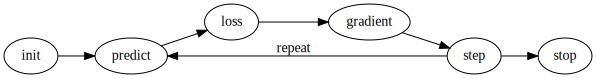

In [ ]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## 머신러닝 분류 모델 만드는데 필요한 단계

1. 가중치 **초기화**: 파라미터 값 무작위로 초기화
2. **예측(predict)**: 현재 가중치로 3 or 7 인지 예측
3. **손실 측정(loss)**: 모델이 얼마나 좋은지
4. **그레이디언트(gradient)**계산: 가중치 갱신 정도가 손실에 미치는 영향
5. 4번에서 계산한 그레이디언트로 가중치 값을 **한 단계(step)** 조정
6. 2번으로 돌아가서 **반복(repeat)**
7. **멈춰도 좋다**는 판단이 설 때 까지 반복: 에포크 횟수를 정하고 시작함. 성능 충분 or 시간 제약일 때 멈추게됨

There are many different ways to do each of these seven steps, and we will be learning about them throughout the rest of this book. These are the details that make a big difference for deep learning practitioners, but it turns out that the general approach to each one generally follows some basic principles. Here are a few guidelines:

- Initialize:: We initialize the parameters to random values. This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well.
- Loss:: This is what Samuel referred to when he spoke of *testing the effectiveness of any current weight assignment in terms of actual performance*. We need some function that will return a number that is small if the performance of the model is good (the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention).
- Step:: A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating *gradients*. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.
- Stop:: Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision. This is where that decision is applied. For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.

### 위의 단계를 간단한 예로 설명

Before applying these steps to our image classification problem, let's illustrate what they look like in a simpler case. First we will define a very simple function, the quadratic—let's pretend that this is our loss function, and `x` is a weight parameter of the function:

In [ ]:
def f(x): return x**2

Here is a graph of that function:

/usr/local/lib/python3.7/dist-packages/fastbook/__init__.py:74: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


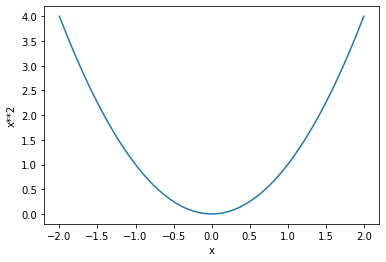

In [ ]:
# 별거 아니고 그래프로 표현한 것
plot_function(f, 'x', 'x**2')

The sequence of steps we described earlier starts by picking some random value for a parameter, and calculating the value of the loss:

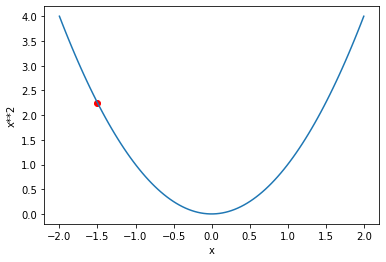

In [ ]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red'); # 임의의 파라미터 선택

Now we look to see what would happen if we increased or decreased our parameter by a little bit—the *adjustment*. This is simply the slope at a particular point:

살짝 조정해보고 기울기 구해서 조정 방향 정함

<img alt="A graph showing the squared function with the slope at one point" width="400" src="https://github.com/fastai/fastbook/blob/master/images/grad_illustration.svg?raw=1"/>

We can change our weight by a little in the direction of the slope, calculate our loss and adjustment again, and repeat this a few times. Eventually, we will get to the lowest point on our curve:

계속 반복하면, 가장 낮은 곳에 도달

<img alt="An illustration of gradient descent" width="400" src="https://github.com/fastai/fastbook/blob/master/images/chapter2_perfect.svg?raw=1"/>

This basic idea goes all the way back to Isaac Newton, who pointed out that we can optimize arbitrary functions in this way. Regardless of how complicated our functions become, this basic approach of gradient descent will not significantly change. The only minor changes we will see later in this book are some handy ways we can make it faster, by finding better steps.

### Calculating Gradients

* 그레이디언트는 모델이 더 나아지려면 갱신해야할 가중치의 정도를 알려줌
* 미분: 값의 변화 정도를 계산
* 그레이디언트: **y의 변화량 / x의 변화량**
* 함수의 그레이디언트를 더 작게 만드는 것 = 머신러닝의 핵심
* 파이토치로는 미분 계산하기 완전 편하다고함. 아래 코드를 봅시다

The one magic step is the bit where we calculate the gradients. As we mentioned, we use calculus as a performance optimization; it allows us to more quickly calculate whether our loss will go up or down when we adjust our parameters up or down. In other words, the gradients will tell us how much we have to change each weight to make our model better.

You may remember from your high school calculus class that the *derivative* of a function tells you how much a change in its parameters will change its result. If not, don't worry, lots of us forget calculus once high school is behind us! But you will have to have some intuitive understanding of what a derivative is before you continue, so if this is all very fuzzy in your head, head over to Khan Academy and complete the [lessons on basic derivatives](https://www.khanacademy.org/math/differential-calculus/dc-diff-intro). You won't have to know how to calculate them yourselves, you just have to know what a derivative is.

The key point about a derivative is this: for any function, such as the quadratic function we saw in the previous section, we can calculate its derivative. The derivative is another function. It calculates the change, rather than the value. For instance, the derivative of the quadratic function at the value 3 tells us how rapidly the function changes at the value 3. More specifically, you may recall that gradient is defined as *rise/run*, that is, the change in the value of the function, divided by the change in the value of the parameter. When we know how our function will change, then we know what we need to do to make it smaller. This is the key to machine learning: having a way to change the parameters of a function to make it smaller. Calculus provides us with a computational shortcut, the derivative, which lets us directly calculate the gradients of our functions.

One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative we won't get back one number, but lots of them—a gradient for every weight. But there is nothing mathematically tricky here; you can calculate the derivative with respect to one weight, and treat all the other ones as constant, then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.

We mentioned just now that you won't have to calculate any gradients yourself. How can that be? Amazingly enough, PyTorch is able to automatically compute the derivative of nearly any function! What's more, it does it very fast. Most of the time, it will be at least as fast as any derivative function that you can create by hand. Let's see an example.

First, let's pick a tensor value which we want gradients at:

In [ ]:
tensor(3.)

tensor(3.)

In [ ]:
# 명쾌한건 아니지만 이렇게 하면 텐서 내부에서 gradient를 알아서 계산해준다고 함
tensor(3.).requires_grad_() # requires_grad=True 옵션을 활성화

tensor(3., requires_grad=True)

In [ ]:
xt = tensor(3.).requires_grad_()

Notice the special method `requires_grad_`? That's the magical incantation we use to tell PyTorch that we want to calculate gradients with respect to that variable at that value. It is essentially tagging the variable, so PyTorch will remember to keep track of how to compute gradients of the other, direct calculations on it that you will ask for.

> a: This API might throw you off if you're coming from math or physics. In those contexts the "gradient" of a function is just another function (i.e., its derivative), so you might expect gradient-related APIs to give you a new function. But in deep learning, "gradients" usually means the _value_ of a function's derivative at a particular argument value. The PyTorch API also puts the focus on the argument, not the function you're actually computing the gradients of. It may feel backwards at first, but it's just a different perspective.

Now we calculate our function with that value. Notice how PyTorch prints not just the value calculated, but also a note that it has a gradient function it'll be using to calculate our gradients when needed:

In [ ]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

Finally, we tell PyTorch to calculate the gradients for us:

In [ ]:
yt.backward() # 그레이디언트 계산

The "backward" here refers to *backpropagation*, which is the name given to the process of calculating the derivative of each layer. We'll see how this is done exactly in chapter <<chapter_foundations>>, when we calculate the gradients of a deep neural net from scratch. This is called the "backward pass" of the network, as opposed to the "forward pass," which is where the activations are calculated. Life would probably be easier if `backward` was just called `calculate_grad`, but deep learning folks really do like to add jargon everywhere they can!

We can now view the gradients by checking the `grad` attribute of our tensor:

In [ ]:
xt.grad # 그레이디언트 결과값

tensor(6.)

If you remember your high school calculus rules, the derivative of `x**2` is `2*x`, and we have `x=3`, so the gradients should be `2*3=6`, which is what PyTorch calculated for us!

Now we'll repeat the preceding steps, but with a vector argument for our function:

In [ ]:
# 벡터 그레디언트 계산해보기
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

And we'll add `sum` to our function so it can take a vector (i.e., a rank-1 tensor), and return a scalar (i.e., a rank-0 tensor):

In [ ]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

Our gradients are `2*xt`, as we'd expect!

In [ ]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

The gradients only tell us the slope of our function, they don't actually tell us exactly how far to adjust the parameters. But it gives us some idea of how far; if the slope is very large, then that may suggest that we have more adjustments to do, whereas if the slope is very small, that may suggest that we are close to the optimal value.

### Stepping With a Learning Rate: 학습률을 사용해 단계 밟아 나가기

* 학습률을 그레이디언트에 곱하는 아이디어
* 학습률: 대부분 0.001 ~ 0.1 사이의 값
* 이 과정을 최적화 단계(optimization step)를 사용한 파라미터의 **갱신단계(stepping)** 라고 함

Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the *learning rate* (LR). The learning rate is often a number between 0.001 and 0.1, although it could be anything. Often, people select a learning rate just by trying a few, and finding which results in the best model after training (we'll show you a better approach later in this book, called the *learning rate finder*). Once you've picked a learning rate, you can adjust your parameters using this simple function:

```
w -= gradient(w) * lr
```

This is known as *stepping* your parameters, using an *optimizer step*.

If you pick a learning rate that's too low, it can mean having to do a lot of steps. <<descent_small>> illustrates that.

<img alt="An illustration of gradient descent with a LR too low" width="400" caption="Gradient descent with low LR" src="https://github.com/fastai/fastbook/blob/master/images/chapter2_small.svg?raw=1" id="descent_small"/>

작은 학습률로 수행되는 경사하강


But picking a learning rate that's too high is even worse—it can actually result in the loss getting *worse*, as we see in <<descent_div>>!

<img alt="An illustration of gradient descent with a LR too high" width="400" caption="Gradient descent with high LR" src="https://github.com/fastai/fastbook/blob/master/images/chapter2_div.svg?raw=1" id="descent_div"/>

큰 학습률로 수행되는 경사하강


If the learning rate is too high, it may also "bounce" around, rather than actually diverging; <<descent_bouncy>> shows how this has the result of taking many steps to train successfully.

<img alt="An illustation of gradient descent with a bouncy LR" width="400" caption="Gradient descent with bouncy LR" src="https://github.com/fastai/fastbook/blob/master/images/chapter2_bouncy.svg?raw=1" id="descent_bouncy"/>

학습률이 지나치면 이리저리 뛰어나니는 현상 발생 😅

Now let's apply all of this in an end-to-end example.

### An End-to-End SGD Example: SGD를 활용한 시작부터 끝까지를 보여주는 예제

* 지금까지 그레이디언트로 손실을 최소화 하는 방법 알아봄
* 이제부터 SGD 살펴보기

### 롤러코스터 속도 계산 예시

- 빠르다가 경사로 올라가면서 느려짐

We've seen how to use gradients to find a minimum. Now it's time to look at an SGD example and see how finding a minimum can be used to train a model to fit data better.

Let's start with a simple, synthetic, example model. Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this:

In [ ]:
time = torch.arange(0,20).float(); time # 20초 동안 측정한다고 가정

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

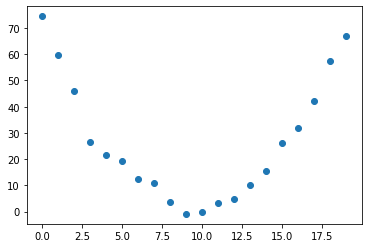

In [ ]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1 # torch.randn(20)*3 예제를 위한 노이즈
plt.scatter(time,speed);

We've added a bit of random noise, since measuring things manually isn't precise. This means it's not that easy to answer the question: what was the roller coaster's speed? Using SGD we can try to find a function that matches our observations. We can't consider every possible function, so let's use a guess that it will be quadratic; i.e., a function of the form `a*(time**2)+(b*time)+c`.

We want to distinguish clearly between the function's input (the time when we are measuring the coaster's speed) and its parameters (the values that define *which* quadratic we're trying). So, let's collect the parameters in one argument and thus separate the input, `t`, and the parameters, `params`, in the function's signature: 

* SGD를 활용하면 관측 데이터에 들어맞는 함수를 찾을 수 있음
* 하지만 모든 함수를 고려하기는 불가능해서, 여기서는 2차 함수라고 가정

In [ ]:
# - t: 입력
# - params: 나머지 파라미터
def f(t, params): 
    a,b,c = params
    return a*(t**2) + (b*t) + c

* 위와 같이 제한하면 가장 적합한 a, b, c를 찾는 문제로 단순해짐
* 가장 적합한 = 올바른 손실 함수를 골라야 함
* 연속적인 값을 예측할 때는 일반적으로 평균제곱오차 사용함

In other words, we've restricted the problem of finding the best imaginable function that fits the data, to finding the best *quadratic* function. This greatly simplifies the problem, since every quadratic function is fully defined by the three parameters `a`, `b`, and `c`. Thus, to find the best quadratic function, we only need to find the best values for `a`, `b`, and `c`.

If we can solve this problem for the three parameters of a quadratic function, we'll be able to apply the same approach for other, more complex functions with more parameters—such as a neural net. Let's find the parameters for `f` first, and then we'll come back and do the same thing for the MNIST dataset with a neural net.

We need to define first what we mean by "best." We define this precisely by choosing a *loss function*, which will return a value based on a prediction and a target, where lower values of the function correspond to "better" predictions. For continuous data, it's common to use *mean squared error*:

In [ ]:
# 이걸 손실함수로 쓰기로함
def mse(preds, targets): return ((preds-targets)**2).mean().sqrt()

Now, let's work through our 7 step process.

#### Step 1: Initialize the parameters

First, we initialize the parameters to random values, and tell PyTorch that we want to track their gradients, using `requires_grad_`:

In [ ]:
params = torch.randn(3).requires_grad_() # 임의값으로 초기화, 그레이디언트 추적 활성화

In [ ]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

Next, we calculate the predictions:

In [ ]:
preds = f(time, params)

Let's create a little function to see how close our predictions are to our targets, and take a look:

In [ ]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

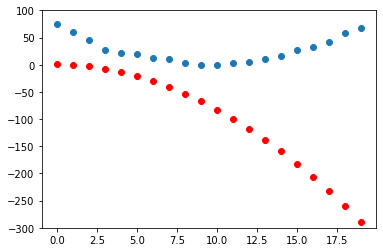

In [ ]:
show_preds(preds) # 임의의 값으로 초기화 되어 있어서, 완전히 다른 값을 예측함

This doesn't look very close—our random parameters suggest that the roller coaster will end up going backwards, since we have negative speeds!

#### Step 3: Calculate the loss

We calculate the loss as follows:

In [ ]:
loss = mse(preds, speed)
loss

tensor(160.6979, grad_fn=<SqrtBackward0>)

Our goal is now to improve this. To do that, we'll need to know the gradients.

#### Step 4: Calculate the gradients

The next step is to calculate the gradients. In other words, calculate an approximation of how the parameters need to change:

In [ ]:
loss.backward()
params.grad

tensor([-165.5151,  -10.6402,   -0.7900])

In [ ]:
params.grad * 1e-5 # le-5(0.00001) = 일단 선택된 학습률

tensor([-1.6552e-03, -1.0640e-04, -7.8996e-06])

We can use these gradients to improve our parameters. We'll need to pick a learning rate (we'll discuss how to do that in practice in the next chapter; for now we'll just use 1e-5, or 0.00001):

In [ ]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

#### Step 5: Step the weights : 가중치 갱신하기

Now we need to update the parameters based on the gradients we just calculated:

In [ ]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

> a: Understanding this bit depends on remembering recent history. To calculate the gradients we call `backward` on the `loss`. But this `loss` was itself calculated by `mse`, which in turn took `preds` as an input, which was calculated using `f` taking as an input `params`, which was the object on which we originally called `required_grads_`—which is the original call that now allows us to call `backward` on `loss`. This chain of function calls represents the mathematical composition of functions, which enables PyTorch to use calculus's chain rule under the hood to calculate these gradients.

Let's see if the loss has improved:

In [ ]:
preds = f(time,params)
mse(preds, speed)

tensor(160.4228, grad_fn=<SqrtBackward0>)

And take a look at the plot:

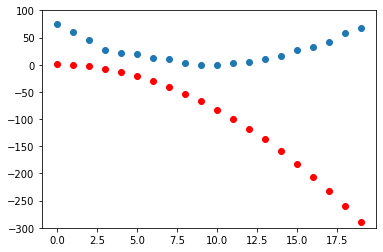

In [ ]:
show_preds(preds)

We need to repeat this a few times, so we'll create a function to apply one step:

In [ ]:
# 앞의 과정을 반복해야 해서 함수로 만듦
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

Now we iterate. By looping and performing many improvements, we hope to reach a good result:

In [ ]:
for i in range(10): apply_step(params)

# loss가 점점 낮아지는 것을 볼 수 있음

160.42279052734375
160.14772033691406
159.87269592285156
159.59768676757812
159.3227081298828
159.04774475097656
158.7728271484375
158.4979248046875
158.22305297851562
157.9481964111328


In [ ]:
#hide
params = orig_params.detach().requires_grad_()

The loss is going down, just as we hoped! But looking only at these loss numbers disguises the fact that each iteration represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function. We can see this process visually if, instead of printing out the loss function, we plot the function at every step. Then we can see how the shape is approaching the best possible quadratic function for our data:

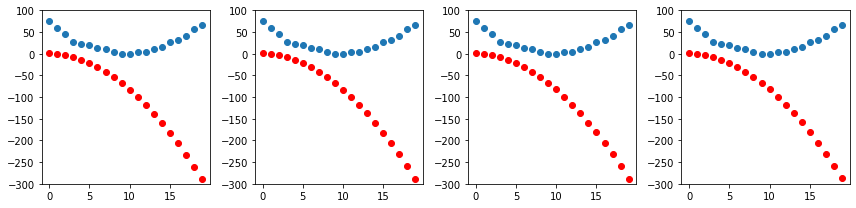

In [ ]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

* 여기서는 10번의 에포크 후에 학습 종료
* 실전에서는 손실 및 평가지표를 보면서 학습 종료 시점을 결정해줘야 함

We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop, as we've discussed.

### Summarizing Gradient Descent

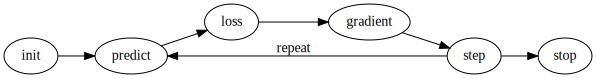

In [ ]:
#hide_input
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

* init
  * 모델 가중치 임의로 설정: from scratch
  * 또는 사전 학습된 모델로 설정: 전이 학습(transfer learning) 
* 더 나은 가중치를 학습
  * 손실 함수로 출력과 목표를 비교
  * 그레이디언트 계산: 기울기 계산
  * 기울기 * 학습률 = 한번에 움직여야 하는 양
  * 이 과정을 반복
  * 도달하면 멈춤

To summarize, at the beginning, the weights of our model can be random (training *from scratch*) or come from a pretrained model (*transfer learning*). In the first case, the output we will get from our inputs won't have anything to do with what we want, and even in the second case, it's very likely the pretrained model won't be very good at the specific task we are targeting. So the model will need to *learn* better weights.

We begin by comparing the outputs the model gives us with our targets (we have labeled data, so we know what result the model should give) using a *loss function*, which returns a number that we want to make as low as possible by improving our weights. To do this, we take a few data items (such as images) from the training set and feed them to our model. We compare the corresponding targets using our loss function, and the score we get tells us how wrong our predictions were. We then change the weights a little bit to make it slightly better.

To find how to change the weights to make the loss a bit better, we use calculus to calculate the *gradients*. (Actually, we let PyTorch do it for us!) Let's consider an analogy. Imagine you are lost in the mountains with your car parked at the lowest point. To find your way back to it, you might wander in a random direction, but that probably wouldn't help much. Since you know your vehicle is at the lowest point, you would be better off going downhill. By always taking a step in the direction of the steepest downward slope, you should eventually arrive at your destination. We use the magnitude of the gradient (i.e., the steepness of the slope) to tell us how big a step to take; specifically, we multiply the gradient by a number we choose called the *learning rate* to decide on the step size. We then *iterate* until we have reached the lowest point, which will be our parking lot, then we can *stop*.

All of that we just saw can be transposed directly to the MNIST dataset, except for the loss function. Let's now see how we can define a good training objective. 

## The MNIST Loss Function

We already have our independent variables `x`—these are the images themselves. We'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). We can do this using `view`, which is a PyTorch method that changes the shape of a tensor without changing its contents. `-1` is a special parameter to `view` that means "make this axis as big as necessary to fit all the data":

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28) # torch.Size([12396, 784]) rank2 텐서로 표현해줌
# 왜 Rank2로 표현해야하는지는 모르겠음...

We need a label for each image. We'll use `1` for 3s and `0` for 7s:

In [ ]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1) # 레이블 만들기. '숫자 3' = 0, '숫자 7' = 1
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [ ]:
dset = list(zip(train_x,train_y)) # 파이토치 Dataset (x,y) 튜플이 필요함
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [ ]:
# 검증용
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we need an (initially random) weight for every pixel (this is the *initialize* step in our seven-step process):

In [ ]:
# init (초기화) 단계: 임의로 초기화 된 가중치
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28,1))

The function `weights*pixels` won't be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its *intercept* is 0). You might remember from high school math that the formula for a line is `y=w*x+b`; we still need the `b`. We'll initialize it to a random number too:

In [ ]:
# 임의의 절편 값
# 0에 가중치르 곱하면 결과물이 0으로 나오기 때문에 절편값 필요함
# 신경망에서는 이걸 **편향(bias)**라고 부름
bias = init_params(1)

In neural networks, the `w` in the equation `y=w*x+b` is called the *weights*, and the `b` is called the *bias*. Together, the weights and bias make up the *parameters*.

> jargon: Parameters: The _weights_ and _biases_ of a model. The weights are the `w` in the equation `w*x+b`, and the biases are the `b` in that equation.

- w = 가중치
- b = 편향

We can now calculate a prediction for one image:

In [ ]:
(train_x[0]*weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

While we could use a Python `for` loop to calculate the prediction for each image, that would be very slow. Because Python loops don't run on the GPU, and because Python is a slow language for loops in general, we need to represent as much of the computation in a model as possible using higher-level functions.

In this case, there's an extremely convenient mathematical operation that calculates `w*x` for every row of a matrix—it's called *matrix multiplication*. <<matmul>> shows what matrix multiplication looks like.

<img alt="Matrix multiplication" width="400" caption="Matrix multiplication" src="https://github.com/fastai/fastbook/blob/master/images/matmul2.svg?raw=1" id="matmul"/>

This image shows two matrices, `A` and `B`, being multiplied together. Each item of the result, which we'll call `AB`, contains each item of its corresponding row of `A` multiplied by each item of its corresponding column of `B`, added together. For instance, row 1, column 2 (the orange dot with a red border) is calculated as $a_{1,1} * b_{1,2} + a_{1,2} * b_{2,2}$. If you need a refresher on matrix multiplication, we suggest you take a look at the [Intro to Matrix Multiplication](https://youtu.be/kT4Mp9EdVqs) on *Khan Academy*, since this is the most important mathematical operation in deep learning.

In Python, matrix multiplication is represented with the `@` operator. Let's try it:

In [ ]:
# @ operator를 써서 행렬곱 계산
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

The first element is the same as we calculated before, as we'd expect. This equation, `batch@weights + bias`, is one of the two fundamental equations of any neural network (the other one is the *activation function*, which we'll see in a moment).

`batch@weights + bias` 모든 신경망의 가장 기본인 방정식 중 하나

Let's check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0.5, so our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [ ]:
train_y

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [ ]:
# 정확도 검사

corrects = (preds>0.5).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [ ]:
corrects.float().mean().item()

0.49080348014831543

Now let's see what the change in accuracy is for a small change in one of the weights:

In [ ]:
# 가중치 하나 바꿨을 때 정확도 변화 확인하기
weights[0].data *= 1.0001 
# 그런데... 저는 .data를 업데이트해야 에러가 안뜨더라구요
# 관련 블로그 글: https://m.blog.naver.com/myincizor/221691061964

In [ ]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4912068545818329

## 손실 함수 정하기

(저는 이 부분 어렵네요 😭😭😭)

### 이슈: 정확도를 손실 함수로 쓸 수 없음

* 정확도를 손실함수로 쓰고 싶지만 쓸 수 없음
* 기술적인 문제가 있음
* 정확도는 예측 결과가 3 -> 7 변하거나, 7 -> 3 변할 때만 바뀌는 값

### 그래서: '약간 더 나은 예측'을 도출한 가중치에 따라, '약간 더 나은 손실'을 계산하는 손실 함수가 필요함

As we've seen, we need gradients in order to improve our model using SGD, and in order to calculate gradients we need some *loss function* that represents how good our model is. That is because the gradients are a measure of how that loss function changes with small tweaks to the weights.

So, we need to choose a loss function. The obvious approach would be to use accuracy, which is our metric, as our loss function as well. In this case, we would calculate our prediction for each image, collect these values to calculate an overall accuracy, and then calculate the gradients of each weight with respect to that overall accuracy.

Unfortunately, we have a significant technical problem here. The gradient of a function is its *slope*, or its steepness, which can be defined as *rise over run*—that is, how much the value of the function goes up or down, divided by how much we changed the input. We can write this in mathematically as: `(y_new - y_old) / (x_new - x_old)`. This gives us a good approximation of the gradient when `x_new` is very similar to `x_old`, meaning that their difference is very small. But accuracy only changes at all when a prediction changes from a 3 to a 7, or vice versa. The problem is that a small change in weights from `x_old` to `x_new` isn't likely to cause any prediction to change, so `(y_new - y_old)` will almost always be 0. In other words, the gradient is 0 almost everywhere.

A very small change in the value of a weight will often not actually change the accuracy at all. This means it is not useful to use accuracy as a loss function—if we do, most of the time our gradients will actually be 0, and the model will not be able to learn from that number.

> S: In mathematical terms, accuracy is a function that is constant almost everywhere (except at the threshold, 0.5), so its derivative is nil almost everywhere (and infinity at the threshold). This then gives gradients that are 0 or infinite, which are useless for updating the model.

Instead, we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. So what does a "slightly better prediction" look like, exactly? Well, in this case, it means that if the correct answer is a 3 the score is a little higher, or if the correct answer is a 7 the score is a little lower.

Let's write such a function now. What form does it take?

The loss function receives not the images themselves, but the predictions from the model. Let's make one argument, `prds`, of values between 0 and 1, where each value is the prediction that an image is a 3. It is a vector (i.e., a rank-1 tensor), indexed over the images.

The purpose of the loss function is to measure the difference between predicted values and the true values — that is, the targets (aka labels). Let's make another argument, `trgts`, with values of 0 or 1 which tells whether an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor), indexed over the images.

So, for instance, suppose we had three images which we knew were a 3, a 7, and a 3. And suppose our model predicted with high confidence (`0.9`) that the first was a 3, with slight confidence (`0.4`) that the second was a 7, and with fair confidence (`0.2`), but incorrectly, that the last was a 7. This would mean our loss function would receive these values as its inputs:

In [ ]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

Here's a first try at a loss function that measures the distance between `predictions` and `targets`:

In [ ]:
# predictions와 targets 사이의 거리를 측정하는 손실 함수
# 정답 1 일 때: 예측 1과 떨어진 정도 측정
# 정답 0 일 때: 예측 0과 떨어진 정도 측정

def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

We're using a new function, `torch.where(a,b,c)`. This is the same as running the list comprehension `[b[i] if a[i] else c[i] for i in range(len(a))]`, except it works on tensors, at C/CUDA speed. In plain English, this function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

> note: Read the Docs: It's important to learn about PyTorch functions like this, because looping over tensors in Python performs at Python speed, not C/CUDA speed! Try running `help(torch.where)` now to read the docs for this function, or, better still, look it up on the PyTorch documentation site.

Let's try it on our `prds` and `trgts`:

In [ ]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

You can see that this function returns a lower number when predictions are more accurate, when accurate predictions are more confident (higher absolute values), and when inaccurate predictions are less confident. In PyTorch, we always assume that a lower value of a loss function is better. Since we need a scalar for the final loss, `mnist_loss` takes the mean of the previous tensor:

In [ ]:
mnist_loss(prds,trgts)

tensor(0.4333)

For instance, if we change our prediction for the one "false" target from `0.2` to `0.8` the loss will go down, indicating that this is a better prediction:

In [ ]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts) # 마지막값을 0.2 -> 0.8 변경하면 더 나은 예측

tensor(0.2333)

One problem with `mnist_loss` as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that—let's take a look.

현재 손실 함수 결과 값이 0~1 사이인데, 0 or 1로 강제해야함. 그걸 해주는 함수가 있음

### Sigmoid

항상 0과 1 사이의 값을 출력해줌

The `sigmoid` function always outputs a number between 0 and 1. It's defined as follows:

In [ ]:
def sigmoid(x): return 1/(1+torch.exp(-x))

Pytorch defines an accelerated version for us, so we don’t really need our own. This is an important function in deep learning, since we often want to ensure values are between 0 and 1. This is what it looks like:

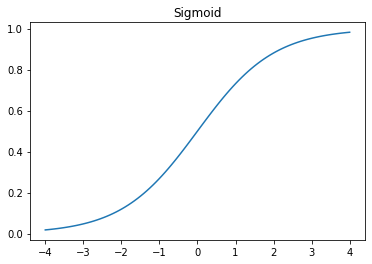

In [ ]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

As you can see, it takes any input value, positive or negative, and smooshes it onto an output value between 0 and 1. It's also a smooth curve that only goes up, which makes it easier for SGD to find meaningful gradients. 

Let's update `mnist_loss` to first apply `sigmoid` to the inputs:

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Now we can be confident our loss function will work, even if the predictions are not between 0 and 1. All that is required is that a higher prediction corresponds to higher confidence an image is a 3.

Having defined a loss function, now is a good moment to recapitulate why we did this. After all, we already had a metric, which was overall accuracy. So why did we define a loss?

The key difference is that the metric is to drive human understanding and the loss is to drive automated learning. To drive automated learning, the loss must be a function that has a meaningful derivative. It can't have big flat sections and large jumps, but instead must be reasonably smooth. This is why we designed a loss function that would respond to small changes in confidence level. This requirement means that sometimes it does not really reflect exactly what we are trying to achieve, but is rather a compromise between our real goal, and a function that can be optimized using its gradient. The loss function is calculated for each item in our dataset, and then at the end of an epoch the loss values are all averaged and the overall mean is reported for the epoch.

Metrics, on the other hand, are the numbers that we really care about. These are the values that are printed at the end of each epoch that tell us how our model is really doing. It is important that we learn to focus on these metrics, rather than the loss, when judging the performance of a model.

### 잘모르겠지만 정리해보면
* 평가지표: 사람의 이해를 돕는 것. 사람을 위한 것
* 손실: 자동화된 학습을 이끌어 가는 것. 시스템을 위한 것

### SGD and Mini-Batches

* 최적화 단계!
* 그레이디언트 기반 가중치 갱신

### 계산하기
* 전체 데이터셋에 대해 손실 평균 구하기 = 너무 오래걸림
* 단일 데이터셋에 대해 손실 평균 구하기 = 부정확, 불안정
* 일정 개수 데이터에 대해 손실 평균 구하기 = 미니배치학습! 절충안

### 미니 배치
* 데이터 개수 = **배치 크기(batch size)**
* 배치 크기 클 수록 = 안정적, 오래 걸림
* GPU 효율적으로 사용 가능

### DataLoader
* 데이터 뒤섞은 다음 미니배치 만들어줌

Now that we have a loss function that is suitable for driving SGD, we can consider some of the details involved in the next phase of the learning process, which is to change or update the weights based on the gradients. This is called an *optimization step*.

In order to take an optimization step we need to calculate the loss over one or more data items. How many should we use? We could calculate it for the whole dataset, and take the average, or we could calculate it for a single data item. But neither of these is ideal. Calculating it for the whole dataset would take a very long time. Calculating it for a single item would not use much information, so it would result in a very imprecise and unstable gradient. That is, you'd be going to the trouble of updating the weights, but taking into account only how that would improve the model's performance on that single item.

So instead we take a compromise between the two: we calculate the average loss for a few data items at a time. This is called a *mini-batch*. The number of data items in the mini-batch is called the *batch size*. A larger batch size means that you will get a more accurate and stable estimate of your dataset's gradients from the loss function, but it will take longer, and you will process fewer mini-batches per epoch. Choosing a good batch size is one of the decisions you need to make as a deep learning practitioner to train your model quickly and accurately. We will talk about how to make this choice throughout this book.

Another good reason for using mini-batches rather than calculating the gradient on individual data items is that, in practice, we nearly always do our training on an accelerator such as a GPU. These accelerators only perform well if they have lots of work to do at a time, so it's helpful if we can give them lots of data items to work on. Using mini-batches is one of the best ways to do this. However, if you give them too much data to work on at once, they run out of memory—making GPUs happy is also tricky!

As we saw in our discussion of data augmentation in <<chapter_production>>, we get better generalization if we can vary things during training. One simple and effective thing we can vary is what data items we put in each mini-batch. Rather than simply enumerating our dataset in order for every epoch, instead what we normally do is randomly shuffle it on every epoch, before we create mini-batches. PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you, called `DataLoader`.

A `DataLoader` can take any Python collection and turn it into an iterator over many batches, like so:

In [ ]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

For training a model, we don't just want any Python collection, but a collection containing independent and dependent variables (that is, the inputs and targets of the model). A collection that contains tuples of independent and dependent variables is known in PyTorch as a `Dataset`. Here's an example of an extremely simple `Dataset`:

In [ ]:
ds = L(enumerate(string.ascii_lowercase)) # 입력과 타겟이 쌍을 이루는 Dataset
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass a `Dataset` to a `DataLoader` we will get back many batches which are themselves tuples of tensors representing batches of independent and dependent variables:

In [ ]:
# Dataset을 DataLoader에 넣어줌
# 독립변수와 종속변수 쌍을 이루는 tensor를 얻을 수 있음
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

We are now ready to write our first training loop for a model using SGD!

## Putting It All Together

It's time to implement the process we saw in <<gradient_descent>>. In code, our process will be implemented something like this for each epoch:

```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

First, let's re-initialize our parameters:

In [ ]:
# 파라미터 초기화
weights = init_params((28*28,1))
bias = init_params(1)

A `DataLoader` can be created from a `Dataset`:

In [ ]:
# 학습용 데이터셋
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

We'll do the same for the validation set:

In [ ]:
# 검증용 데이터셋
valid_dl = DataLoader(valid_dset, batch_size=256)

Let's create a mini-batch of size 4 for testing:

In [ ]:
# 크기 4인 미니배치 만들기
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [ ]:
# 예측
preds = linear1(batch)
preds

tensor([[-2.1876],
        [-8.3973],
        [ 2.5000],
        [-4.9473]], grad_fn=<AddBackward0>)

In [ ]:
# 손실
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.7419, grad_fn=<MeanBackward0>)

Now we can calculate the gradients:

In [ ]:
# graident 계산
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0061), tensor([-0.0420]))

Let's put that all in a function:

In [ ]:
# 위의 내용을 함수로 정의
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

and test it:

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0121), tensor([-0.0840]))

But look what happens if we call it twice:

In [ ]:
# 한번 더 함수를 호출하면 결과값이 변함
# loost.backward가 gradient를 누적시키기 때문
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0182), tensor([-0.1260]))

The gradients have changed! The reason for this is that `loss.backward` actually *adds* the gradients of `loss` to any gradients that are currently stored. So, we have to set the current gradients to 0 first:

In [ ]:
# 이전의 그레이디언트를 0으로 설정
# 파이토치 연산자 중에 _로 끝나는 경우 '제자리 연산자' 라고 부름
weights.grad.zero_()
bias.grad.zero_();

> note: Inplace Operations: Methods in PyTorch whose names end in an underscore modify their objects _in place_. For instance, `bias.zero_()` sets all elements of the tensor `bias` to 0.

Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

In [ ]:
# 하나의 에포크에서 수행되는 학습 루프
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [ ]:
# 정확도 확인
(preds>0.5).float() == train_y[:4]

tensor([[False],
        [False],
        [ True],
        [False]])

That gives us this function to calculate our validation accuracy:

In [ ]:
# 배치 단위의 평균 정확도
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

We can check it works:

In [ ]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)

and then put the batches together:

In [ ]:
# batch_accuracy 결과들의 평균 
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [ ]:
validate_epoch(linear1)

0.5263

That's our starting point. Let's train for one epoch, and see if the accuracy improves:

In [ ]:
# 에포크 한번만 돌려보자
# 정확도 개선되는지 확인해보기
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6663

Then do a few more:

In [ ]:
# 에포크 여러번 반복
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8265 0.89 0.9183 0.9276 0.9398 0.9466 0.9505 0.9525 0.9559 0.9578 0.9598 0.9608 0.9613 0.9618 0.9632 0.9637 0.9647 0.9657 0.9671 0.9676 

Looking good! We're already about at the same accuracy as our "pixel similarity" approach, and we've created a general-purpose foundation we can build on. Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it's called an *optimizer*.

굳! 이 SGD 단계를 객체로 포장해봅시다

### Creating an Optimizer

Because this is such a general foundation, PyTorch provides some useful classes to make it easier to implement. The first thing we can do is replace our `linear1` function with PyTorch's `nn.Linear` module. A *module* is an object of a class that inherits from the PyTorch `nn.Module` class. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

`nn.Linear` does the same thing as our `init_params` and `linear` together. It contains both the *weights* and *biases* in a single class. Here's how we replicate our model from the previous section:

In [ ]:
# init_params 및 linear 작동을 수행
# 클래스 내부에 가중치와 편향이 저장됨
linear_model = nn.Linear(28*28,1)

Every PyTorch module knows what parameters it has that can be trained; they are available through the `parameters` method:

In [ ]:
# 파이토치 모듈은 '학습될 수 있는 파라미터'를 알고 있음
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to create an optimizer:

In [ ]:
# 이 파라미터를 Optimizer의 init에 넣어서 활용 
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

We can create our optimizer by passing in the model's parameters:

In [ ]:
opt = BasicOptim(linear_model.parameters(), lr)

Our training loop can now be simplified to:

In [ ]:
# 이제 학습 루프 더 간소화 할 수 있음
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

Our validation function doesn't need to change at all:

In [ ]:
validate_epoch(linear_model)

0.4606

Let's put our little training loop in a function, to make things simpler:

In [ ]:
# 학습루프 + 정확도 보기
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

The results are the same as in the previous section:

In [ ]:
train_model(linear_model, 20)

0.4932 0.7685 0.8554 0.9135 0.9345 0.9482 0.957 0.9633 0.9658 0.9677 0.9697 0.9716 0.9736 0.9745 0.976 0.977 0.9775 0.9775 0.978 0.9785 

fastai provides the `SGD` class which, by default, does the same thing as our `BasicOptim`:

In [ ]:
# BasicOptim 대신 fastai.SGD 클래스 사용하기
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8178 0.8496 0.914 0.9345 0.9482 0.957 0.9619 0.9658 0.9672 0.9692 0.9711 0.9741 0.975 0.976 0.9775 0.9775 0.978 0.9785 0.9789 

fastai also provides `Learner.fit`, which we can use instead of `train_model`. To create a `Learner` we first need to create a `DataLoaders`, by passing in our training and validation `DataLoader`s:

In [ ]:
# train_model대신 fastai.Learner.fit사용하기
# Learner 생성하려면 DataLoaders 필요 
dls = DataLoaders(dl, valid_dl)

To create a `Learner` without using an application (such as `cnn_learner`) we need to pass in all the elements that we've created in this chapter: the `DataLoaders`, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

In [ ]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

Now we can call `fit`:

In [ ]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636709,0.503144,0.495584,00:00
1,0.429828,0.248517,0.777233,00:00
2,0.161680,0.155361,0.861629,00:00
3,0.072948,0.097722,0.917566,00:00
4,0.040128,0.073205,0.936212,00:00
5,0.027210,0.059466,0.950442,00:00
6,0.021837,0.050799,0.957802,00:00
7,0.019398,0.044980,0.964181,00:00
8,0.018122,0.040853,0.966143,00:00
9,0.017330,0.037788,0.968106,00:00


As you can see, there's nothing magic about the PyTorch and fastai classes. They are just convenient pre-packaged pieces that make your life a bit easier! (They also provide a lot of extra functionality we'll be using in future chapters.)

With these classes, we can now replace our linear model with a neural network.

## Adding a Nonlinearity: 선형모델 -> 신경망 모델로 바꿔보기

* 지금까지 배운 것
  * 파라미터 최적화하는 일반적인 과정
  * 단순 선형 분류 모델 구현

* 선형 모델은 한계 있음
* 복잡한 일을 위해 -> 모델을 더 복잡하게 바꿔야함
* 2개의 선형 계층 사이에 비선형을 추가하면 됨 = 신경망

So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

Here is the entire definition of a basic neural network:

In [ ]:
def simple_net(xb): 
    res = xb@w1 + b1 # 선형
    res = res.max(tensor(0.0)) # 비선형(nonlinear)
    res = res@w2 + b2 # 선형
    return res

# 이렇게하면 선형 계층이 분리되어 각각 자신만의 유용한 일을 할 수 있게 된다고 함...

That's it! All we have in `simple_net` is two linear classifiers with a `max` function between them.

Here, `w1` and `w2` are weight tensors, and `b1` and `b2` are bias tensors; that is, parameters that are initially randomly initialized, just like we did in the previous section:

In [ ]:
# 임의로 초기화
# w: 가중치
# b: 편향

w1 = init_params((28*28,30)) # 출력 활성 30개 = 28x28 픽셀로 서로 다른 특징 30개 구성가능
b1 = init_params(30)
w2 = init_params((30,1)) # w1에 맞물밀 수 있게 입력 활성 30개
b2 = init_params(1)

The key point about this is that `w1` has 30 output activations (which means that `w2` must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels. You can change that `30` to anything you like, to make the model more or less complex.

That little function `res.max(tensor(0.0))` is called a *rectified linear unit*, also known as *ReLU*. We think we can all agree that *rectified linear unit* sounds pretty fancy and complicated... But actually, there's nothing more to it than `res.max(tensor(0.0))`—in other words, replace every negative number with a zero. This tiny function is also available in PyTorch as `F.relu`:

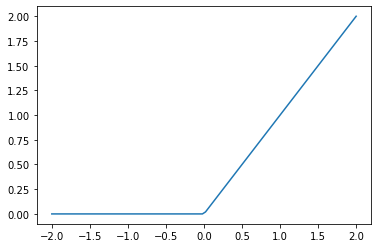

In [ ]:
# res.max(tensor(0.0)) = F.relu 똑같음
# 모든 음숫값을 0으로 교체해줌

plot_function(F.relu)

> J: There is an enormous amount of jargon in deep learning, including terms like _rectified linear unit_. The vast vast majority of this jargon is no more complicated than can be implemented in a short line of code, as we saw in this example. The reality is that for academics to get their papers published they need to make them sound as impressive and sophisticated as possible. One of the ways that they do that is to introduce jargon. Unfortunately, this has the result that the field ends up becoming far more intimidating and difficult to get into than it should be. You do have to learn the jargon, because otherwise papers and tutorials are not going to mean much to you. But that doesn't mean you have to find the jargon intimidating. Just remember, when you come across a word or phrase that you haven't seen before, it will almost certainly turn out to be referring to a very simple concept.

The basic idea is that by using more linear layers, we can have our model do more computation, and therefore model more complex functions. But there's no point just putting one linear layer directly after another one, because when we multiply things together and then add them up multiple times, that could be replaced by multiplying different things together and adding them up just once! That is to say, a series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.

But if we put a nonlinear function between them, such as `max`, then this is no longer true. Now each linear layer is actually somewhat decoupled from the other ones, and can do its own useful work. The `max` function is particularly interesting, because it operates as a simple `if` statement.

> S: Mathematically, we say the composition of two linear functions is another linear function. So, we can stack as many linear classifiers as we want on top of each other, and without nonlinear functions between them, it will just be the same as one linear classifier.

Amazingly enough, it can be mathematically proven that this little function can solve any computable problem to an arbitrarily high level of accuracy, if you can find the right parameters for `w1` and `w2` and if you make these matrices big enough. For any arbitrarily wiggly function, we can approximate it as a bunch of lines joined together; to make it closer to the wiggly function, we just have to use shorter lines. This is known as the *universal approximation theorem*. The three lines of code that we have here are known as *layers*. The first and third are known as *linear layers*, and the second line of code is known variously as a *nonlinearity*, or *activation function*.

Just like in the previous section, we can replace this code with something a bit simpler, by taking advantage of PyTorch:

In [ ]:
# 아래는 여러 계층을 표현함
simple_net = nn.Sequential(
    nn.Linear(28*28,30), # 선형 계층
    nn.ReLU(), # 비선형성 or 활성화 함수
    nn.Linear(30,1) # 선형 계층
)

`nn.Sequential` creates a module that will call each of the listed layers or functions in turn.

`nn.ReLU` is a PyTorch module that does exactly the same thing as the `F.relu` function. Most functions that can appear in a model also have identical forms that are modules. Generally, it's just a case of replacing `F` with `nn` and changing the capitalization. When using `nn.Sequential`, PyTorch requires us to use the module version. Since modules are classes, we have to instantiate them, which is why you see `nn.ReLU()` in this example. 

Because `nn.Sequential` is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. Let's try it out! As this is a deeper model, we'll use a lower learning rate and a few more epochs.

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
# 이전보다 학습률 낮추고 에포크 횟수 높임 
# 더 깊은 모델을 만들었기 때문이라고 함 (어떤 의미인지 잘 모르겠음)
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.281497,0.410105,0.505888,00:00
1,0.135123,0.221296,0.810599,00:00
2,0.076352,0.113494,0.916585,00:00
3,0.051061,0.077187,0.942591,00:00
4,0.039184,0.060455,0.955839,00:00
5,0.033039,0.051038,0.963199,00:00
6,0.029466,0.045099,0.965162,00:00
7,0.027121,0.041028,0.967615,00:00
8,0.025420,0.038060,0.968597,00:00
9,0.024097,0.035784,0.970069,00:00


We're not showing the 40 lines of output here to save room; the training process is recorded in `learn.recorder`, with the table of output stored in the `values` attribute, so we can plot the accuracy over training as:

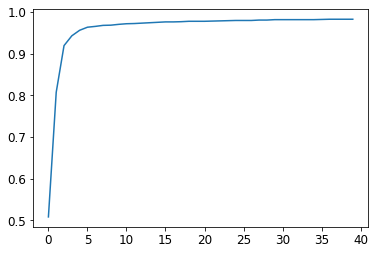

In [ ]:
# 학습 과정에 따른 정확도 그래프
# - 위의 학습과정은 learn.recorder에 기록됨
# - itemgot은 특정 index에 해당되는 값만 튜플로 만들어 줌

plt.plot(L(learn.recorder.values).itemgot(2));

And we can view the final accuracy:

In [ ]:
# 마지막 정확도
learn.recorder.values[-1][2]

0.983316957950592

👍 딥러닝이 환상적인 일을 해낼 수 있는 이유
1. 올바른 파라미터 -> 원하는 문제를 원하는 정확도로 풀어낼 수 있는 함수 (신경망)
2. 모든 함수에 대한 최적의 파라미터 찾는 방법 (SGD)

At this point we have something that is rather magical:

1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
1. A way to find the best set of parameters for any function (stochastic gradient descent)

This is why deep learning can do things which seem rather magical, such fantastic things. Believing that this combination of simple techniques can really solve any problem is one of the biggest steps that we find many students have to take. It seems too good to be true—surely things should be more difficult and complicated than this? Our recommendation: try it out! We just tried it on the MNIST dataset and you have seen the results. And since we are doing everything from scratch ourselves (except for calculating the gradients) you know that there is no special magic hiding behind the scenes.

### Going Deeper: 좀 더 깊은 모델

### 계층 추가
* 계층은 계속 추가할 수 있음
* 하지만 모델이 깊어지면 -> 파라미터 최적화 어려워짐 (나중에 배움)

### 깊은 모델 필요한 이유
* 선형 + 비선형 + 선형 = 모든 함수를 근사하는데 충분
* 그런데도 깊은 모델이 필표한 이유 = 성능
* 더 많은 계층의 작은 행렬 > 적은 계층의 큰 행렬
* 메모리를 덜 차지하는 방식

There is no need to stop at just two linear layers. We can add as many as we want, as long as we add a nonlinearity between each pair of linear layers. As you will learn, however, the deeper the model gets, the harder it is to optimize the parameters in practice. Later in this book you will learn about some simple but brilliantly effective techniques for training deeper models.

We already know that a single nonlinearity with two linear layers is enough to approximate any function. So why would we use deeper models? The reason is performance. With a deeper model (that is, one with more layers) we do not need to use as many parameters; it turns out that we can use smaller matrices with more layers, and get better results than we would get with larger matrices, and few layers.

That means that we can train the model more quickly, and it will take up less memory. In the 1990s researchers were so focused on the universal approximation theorem that very few were experimenting with more than one nonlinearity. This theoretical but not practical foundation held back the field for years. Some researchers, however, did experiment with deep models, and eventually were able to show that these models could perform much better in practice. Eventually, theoretical results were developed which showed why this happens. Today, it is extremely unusual to find anybody using a neural network with just one nonlinearity.

Here what happens when we train an 18-layer model using the same approach we saw in <<chapter_intro>>:

In [ ]:
# 1장과 같은 방식, 18계층 모델
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.083911,0.014109,0.996565,03:37


Nearly 100% accuracy! That's a big difference compared to our simple neural net. But as you'll learn in the remainder of this book, there are just a few little tricks you need to use to get such great results from scratch yourself. You already know the key foundational pieces. (Of course, even once you know all the tricks, you'll nearly always want to work with the pre-built classes provided by PyTorch and fastai, because they save you having to think about all the little details yourself.)

## Jargon Recap

고생많으셨습니다😭😭😭 요약해봅시다!!

## 🌟 가장 중요한 두 전문용어
- **활성(Activations)**: (선형 및 비선형 계층에서) 계산된 수
- **파라미터(Parameters)**: 임의로 초기화되고 최적화된 수 (즉 모델을 정의하는 수)

## 🗂 텐서
- 활성과 파라미터는 텐서로 저장됨
- 텐서는 행렬같은 배열
- 행렬은 행과 열로 구성 = 축 or 차원 이라고 부름
- 랭크0 = 스칼라, 랭크1 = 벡터, 랭크2 = 행렬

## 📚 계층
- 선형 or 비선형
- 선형 계층 1번 + 비선형 계층 1번 = 하나의 계층이라고 하는 사람도 있음
- 비선형 = 활성화 함수

## 📝 SGD 용어
- ReLU: 양수 그대로, 음수 0으로 변환
- 미니배치: 두 배열에 모인 입력과 타겟의 작은 그룹. 미니배치 단위로 경사하강 수행
- 순전파(forward pass): 모델(입력) -> 예측
- 손실(loss): 모델의 수행력을 값으로 표현
- gardient: 손실을 미분한 값
- 역전파(backward pass): 손실 그레이디언트를 계산하는 과정
- 경사 하강: 그레이디언트의 반대 방향으로 나아가는 한번의 단계
- 학습률: SGD를 적용하여 파라미터가 갱신되어야하는 크기

Congratulations: you now know how to create and train a deep neural network from scratch! We've gone through quite a few steps to get to this point, but you might be surprised at how simple it really is.

Now that we are at this point, it is a good opportunity to define, and review, some jargon and key concepts.

A neural network contains a lot of numbers, but they are only of two types: numbers that are calculated, and the parameters that these numbers are calculated from. This gives us the two most important pieces of jargon to learn:


- Activations:: Numbers that are calculated (both by linear and nonlinear layers)
- Parameters:: Numbers that are randomly initialized, and optimized (that is, the numbers that define the model)

We will often talk in this book about activations and parameters. Remember that they have very specific meanings. They are numbers. They are not abstract concepts, but they are actual specific numbers that are in your model. Part of becoming a good deep learning practitioner is getting used to the idea of actually looking at your activations and parameters, and plotting them and testing whether they are behaving correctly.

Our activations and parameters are all contained in *tensors*. These are simply regularly shaped arrays—for example, a matrix. Matrices have rows and columns; we call these the *axes* or *dimensions*. The number of dimensions of a tensor is its *rank*. There are some special tensors:

- Rank zero: scalar
- Rank one: vector
- Rank two: matrix

A neural network contains a number of layers. Each layer is either *linear* or *nonlinear*. We generally alternate between these two kinds of layers in a neural network. Sometimes people refer to both a linear layer and its subsequent nonlinearity together as a single layer. Yes, this is confusing. Sometimes a nonlinearity is referred to as an *activation function*.

<<dljargon1>> summarizes the key concepts related to SGD.

```asciidoc
[[dljargon1]]
.Deep learning vocabulary
[options="header"]
|=====
| Term | Meaning
|ReLU | Function that returns 0 for negative numbers and doesn't change positive numbers.
|Mini-batch | A small group of inputs and labels gathered together in two arrays. A gradient descent step is updated on this batch (rather than a whole epoch).
|Forward pass | Applying the model to some input and computing the predictions.
|Loss | A value that represents how well (or badly) our model is doing.
|Gradient | The derivative of the loss with respect to some parameter of the model.
|Backward pass | Computing the gradients of the loss with respect to all model parameters.
|Gradient descent | Taking a step in the directions opposite to the gradients to make the model parameters a little bit better.
|Learning rate | The size of the step we take when applying SGD to update the parameters of the model.
|=====
```

> note: _Choose Your Own Adventure_ Reminder: Did you choose to skip over chapters 2 & 3, in your excitement to peek under the hood? Well, here's your reminder to head back to chapter 2 now, because you'll be needing to know that stuff very soon!

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.